# Mini project 2

In [1]:
from data import load_dataset, filter_dataset
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd

import urllib.request
import os, sys
import scienceplots
# plt.style.use('nature')
plt.style.use(['science','notebook'])

In [2]:
# Import dataset
X_full,y_full = load_dataset()
X,y = filter_dataset(X_full,y_full,"1,7")
X = X / 255
print(X.shape)
print(y.shape)

(15170, 784)
(15170,)


In [3]:
max(X_full[0]), max(X[0])

(np.int64(255), np.float64(1.0))

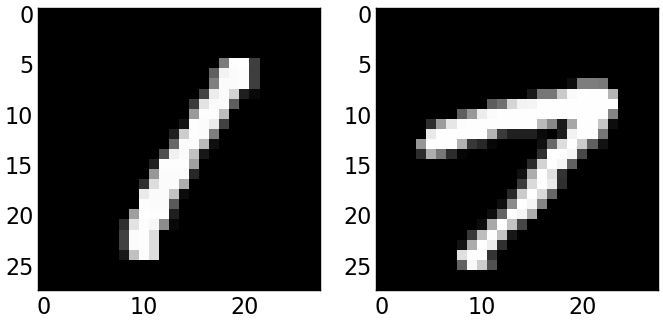

In [4]:
# Plot the squared images
fig, ax = plt.subplots(1, 2)
ax[0].imshow(X[0].reshape(28,28), cmap='gray')
ax[1].imshow(X[45].reshape(28,28), cmap='gray')
plt.show()

In [11]:
# Perform PCA on the dataset
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print("Total variance capture by PCA: ", sum(pca.explained_variance_ratio_))
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X)

Total variance capture by PCA:  0.3685148845976608


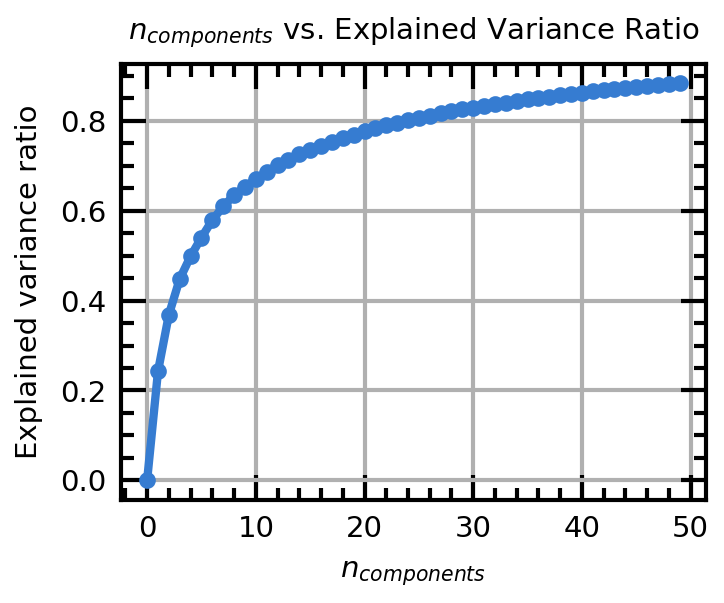

In [15]:
# Study effect of n_components on explained variance ratio
nums = np.arange(50)
 
var_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  X_pca = pca.fit_transform(X)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

color = '#367CD1'

mm = 1 / 25.4

fig, ax = plt.subplots(figsize=(64*mm, 48*mm), dpi=300)
ax.plot(nums,var_ratio,marker='o', color=color)
ax.set_xlabel(r'$n_{components}$', fontsize=7)
ax.set_ylabel('Explained variance ratio', fontsize=7)
ax.set_title(r'$n_{components}$ vs. Explained Variance Ratio', fontsize=7)
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=7)
# fig.savefig('youname.png', dpi=300, bbox_inches='tight')

plt.show()


# plt.figure(figsize=(6,4),dpi=300)
# plt.grid()
# plt.plot(nums,var_ratio,marker='o')
# plt.xlabel(r'$n_{components}$')
# plt.ylabel('Explained variance ratio')
# plt.title('n_components vs. Explained Variance Ratio')

In [5]:
# LDA proves to be much better, since we care more about class separation and nor variance
lda = LinearDiscriminantAnalysis(n_components=1)
Xs = StandardScaler().fit_transform(X)
X_lda = lda.fit_transform(Xs, y)
print("Total variance capture by LDA: ", sum(lda.explained_variance_ratio_))
print("New feature-space shape: ", X_lda.shape)

Total variance capture by LDA:  1.0
New feature-space shape:  (15170, 1)


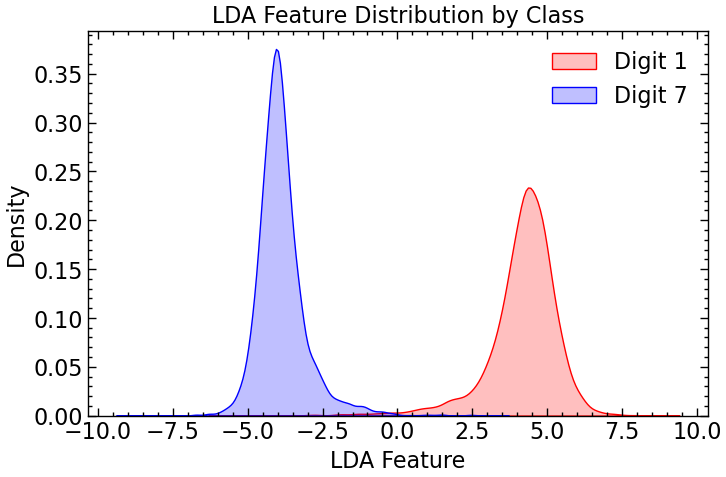

In [6]:
# Plot LDA
# Scatter plot along a single axis (1D)
plt.figure(figsize=(8, 5))
sns.kdeplot(x=X_lda.ravel(), hue=y, fill=True, palette=['blue', 'red'])
plt.xlabel("LDA Feature")
plt.ylabel("Density")
plt.title("LDA Feature Distribution by Class")
plt.legend(["Digit 1", "Digit 7"])
plt.show()

In [7]:
Xtest=np.concatenate(X_lda[200:])
ytest=y[200:]
Xpool=np.concatenate(X_lda[:200])
ypool=y[:200]

In [8]:
import sklearn.linear_model as lin
lr = lin.LogisticRegression(penalty='l2',C=1.)
model=lr

#randomize order of pool to avoid sampling the same subject sequentially
order=np.random.permutation(range(len(Xpool)))

In [14]:
#samples in the pool
poolidx=np.arange(len(Xpool),dtype=np.int64)
ninit = 10 #initial samples
addn = 5 #samples to add each iteration

#initial training set
trainset=order[:ninit]
Xtrain=np.take(Xpool,trainset,axis=0).reshape(-1, 1)
ytrain=np.take(ypool,trainset,axis=0)

#remove data from pool
poolidx=np.setdiff1d(poolidx,trainset)

testacc=[]
for i in range(30):
    #Fit model
    model.fit(np.take(Xpool,order[:ninit+i*addn],axis=0).reshape(-1, 1), np.take(ypool,order[:ninit+i*addn],axis=0))
    #predict on test set
    ye=model.predict(Xtest.reshape(-1, 1))
    #calculate and accuracy and add to list
    testacc.append((ninit+i*addn,sklearn.metrics.accuracy_score(ytest,ye)))
    print('Model: LR, %i random samples'%(ninit+i*addn))

Model: LR, 10 random samples
Model: LR, 15 random samples
Model: LR, 20 random samples
Model: LR, 25 random samples
Model: LR, 30 random samples
Model: LR, 35 random samples
Model: LR, 40 random samples
Model: LR, 45 random samples
Model: LR, 50 random samples
Model: LR, 55 random samples
Model: LR, 60 random samples
Model: LR, 65 random samples
Model: LR, 70 random samples
Model: LR, 75 random samples
Model: LR, 80 random samples
Model: LR, 85 random samples
Model: LR, 90 random samples
Model: LR, 95 random samples
Model: LR, 100 random samples
Model: LR, 105 random samples
Model: LR, 110 random samples
Model: LR, 115 random samples
Model: LR, 120 random samples
Model: LR, 125 random samples
Model: LR, 130 random samples
Model: LR, 135 random samples
Model: LR, 140 random samples
Model: LR, 145 random samples
Model: LR, 150 random samples
Model: LR, 155 random samples


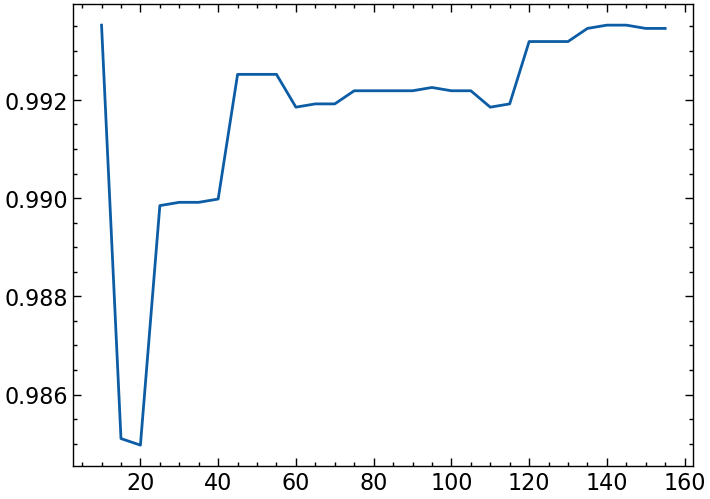

In [15]:
#Plot learning curve
plt.plot(*tuple(np.array(testacc).T));

In [13]:
#reset training set and pool
testacc_qbc=[] #this should hold the final accuracies
ncomm=10
ninit=10
addn=5

trainset=order[:ninit]
Xtrain=np.take(Xpool,trainset,axis=0)
# Reshape Xtrain to be 2D
Xtrain = Xtrain.reshape(-1, 1)

ytrain=np.take(ypool,trainset,axis=0)

poolidx=np.arange(len(Xpool),dtype=np.int64)
poolidx=np.setdiff1d(poolidx,trainset)

for i in range(30):
    ypool_lab=[]
    # fit models in committee
    for k in range(ncomm):
        #bootstrapping
        Xtr,ytr=sklearn.utils.resample(Xtrain,ytrain,stratify=ytrain)
        #fit
        model.fit(Xtr, ytr)
        # Predict
        Xpool_lda = Xpool[poolidx].reshape(-1, 1)
        ypool_lab.append(model.predict(Xpool_lda))

    #get probability of label for each class based on voting in the committee
    ypool_p=(np.mean(np.array(ypool_lab)==1,0),np.mean(np.array(ypool_lab)==7,0))
    ypool_p=np.array(ypool_p).T
    #Refit model in all training data
    model.fit(Xtrain,ytrain)
    Xtest_lda = Xtest.reshape(-1, 1)
    ye=model.predict(Xtest_lda)
    testacc_qbc.append((len(Xtrain),sklearn.metrics.accuracy_score(ytest,ye)))

    #select sample with maximum disagreement (least confident)
    ypool_p_sort_idx = np.argsort(-ypool_p.max(1)) #least confident

    # Add to training set
    Xtrain_new = Xpool[poolidx[ypool_p_sort_idx[-addn:]]]
    # Reshape Xtrain_new to be 2D
    Xtrain_new = Xtrain_new.reshape(-1, 1)
    Xtrain = np.concatenate((Xtrain, Xtrain_new))
    ytrain = np.concatenate((ytrain, ypool[poolidx[ypool_p_sort_idx[-addn:]]]))
    # #add to training set
    # Xtrain=np.concatenate((Xtrain,Xpool[poolidx[ypool_p_sort_idx[-addn:]]]))
    # ytrain=np.concatenate((ytrain,ypool[poolidx[ypool_p_sort_idx[-addn:]]]))

    #remove from pool
    poolidx=np.setdiff1d(poolidx,poolidx[ypool_p_sort_idx[-addn:]])
    print('Model: LR, %i samples (QBC)'%(ninit+i*addn))


Model: LR, 10 samples (QBC)
Model: LR, 15 samples (QBC)
Model: LR, 20 samples (QBC)
Model: LR, 25 samples (QBC)
Model: LR, 30 samples (QBC)
Model: LR, 35 samples (QBC)
Model: LR, 40 samples (QBC)
Model: LR, 45 samples (QBC)
Model: LR, 50 samples (QBC)
Model: LR, 55 samples (QBC)
Model: LR, 60 samples (QBC)
Model: LR, 65 samples (QBC)
Model: LR, 70 samples (QBC)
Model: LR, 75 samples (QBC)
Model: LR, 80 samples (QBC)
Model: LR, 85 samples (QBC)
Model: LR, 90 samples (QBC)
Model: LR, 95 samples (QBC)
Model: LR, 100 samples (QBC)
Model: LR, 105 samples (QBC)
Model: LR, 110 samples (QBC)
Model: LR, 115 samples (QBC)
Model: LR, 120 samples (QBC)
Model: LR, 125 samples (QBC)
Model: LR, 130 samples (QBC)
Model: LR, 135 samples (QBC)
Model: LR, 140 samples (QBC)
Model: LR, 145 samples (QBC)
Model: LR, 150 samples (QBC)
Model: LR, 155 samples (QBC)


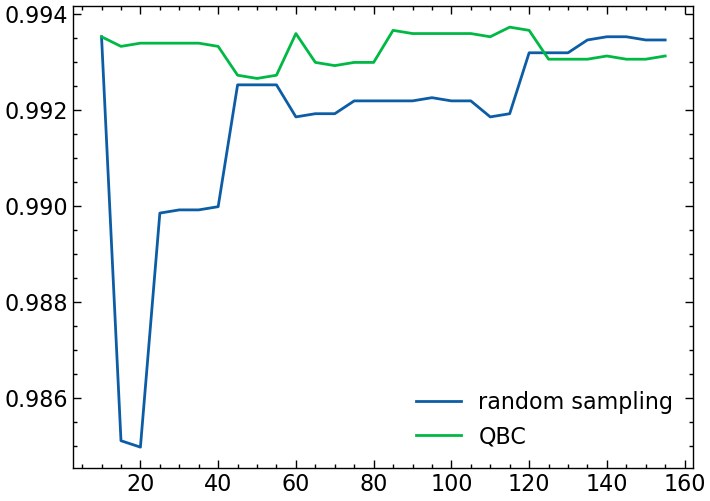

In [16]:
#Plot learning curve
plt.plot(*tuple(np.array(testacc).T));
plt.plot(*tuple(np.array(testacc_qbc).T));
plt.legend(('random sampling','QBC'));

## Train with more classes: 1, 7, 9

In [17]:
# Import dataset with 1,7,9
X_full,y_full = load_dataset()
X,y = filter_dataset(X_full,y_full,"1,7,9")
X = X / 255
print(X.shape)
print(y.shape)

(22128, 784)
(22128,)


In [19]:
print(y)

['1' '9' '1' ... '7' '9' '1']


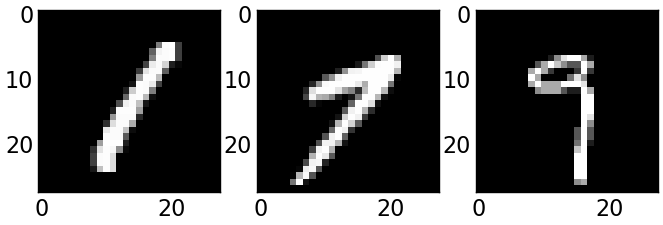

In [18]:
# Plot the squared images
fig, ax = plt.subplots(1, 3)
ax[0].imshow(X[0].reshape(28,28), cmap='gray')
ax[1].imshow(X[50].reshape(28,28), cmap='gray')
ax[2].imshow(X[100].reshape(28,28), cmap='gray')
plt.show()

In [53]:
# Perform PCA on the dataset
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print("Total variance capture by PCA: ", sum(pca.explained_variance_ratio_))
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X)
print("Total variance capture by PCA: ", sum(pca.explained_variance_ratio_))

Total variance capture by PCA:  0.2879082182349692
Total variance capture by PCA:  0.19463251947009771


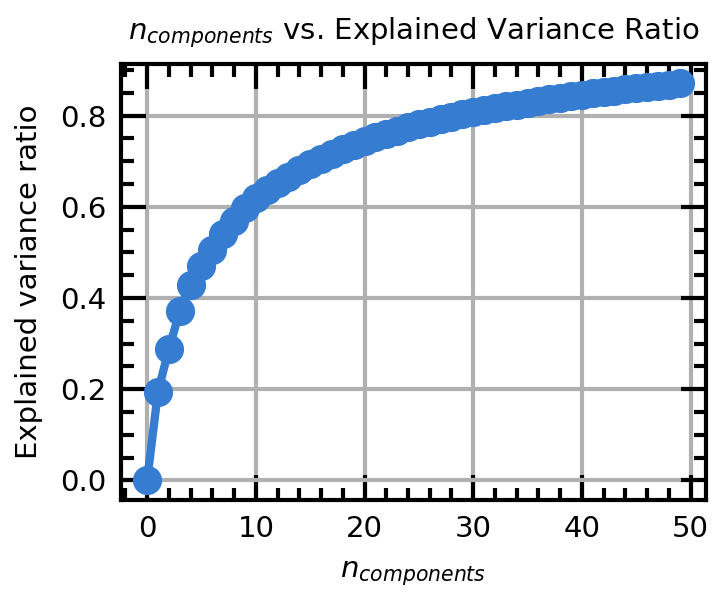

In [52]:
# Study effect of n_components on explained variance ratio
nums = np.arange(50)
 
var_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  X_pca = pca.fit_transform(X)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

color = '#367CD1'

mm = 1 / 25.4

fig, ax = plt.subplots(figsize=(64*mm, 48*mm), dpi=300)
ax.plot(nums,var_ratio,marker='o', color=color)
ax.set_xlabel(r'$n_{components}$', fontsize=7)
ax.set_ylabel('Explained variance ratio', fontsize=7)
ax.set_title(r'$n_{components}$ vs. Explained Variance Ratio', fontsize=7)
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=7)
# fig.savefig('youname.png', dpi=300, bbox_inches='tight')

plt.show()


# plt.figure(figsize=(6,4),dpi=300)
# plt.grid()
# plt.plot(nums,var_ratio,marker='o')
# plt.xlabel(r'$n_{components}$')
# plt.ylabel('Explained variance ratio')
# plt.title('n_components vs. Explained Variance Ratio')

In [20]:
# LDA proves to be much better, since we care more about class separation and nor variance
lda = LinearDiscriminantAnalysis(n_components=2)
Xs = StandardScaler().fit_transform(X)
X_lda = lda.fit_transform(Xs, y)
print("Total variance capture by LDA: ", sum(lda.explained_variance_ratio_))
print("New feature-space shape: ", X_lda.shape)

Total variance capture by LDA:  1.0
New feature-space shape:  (22128, 2)


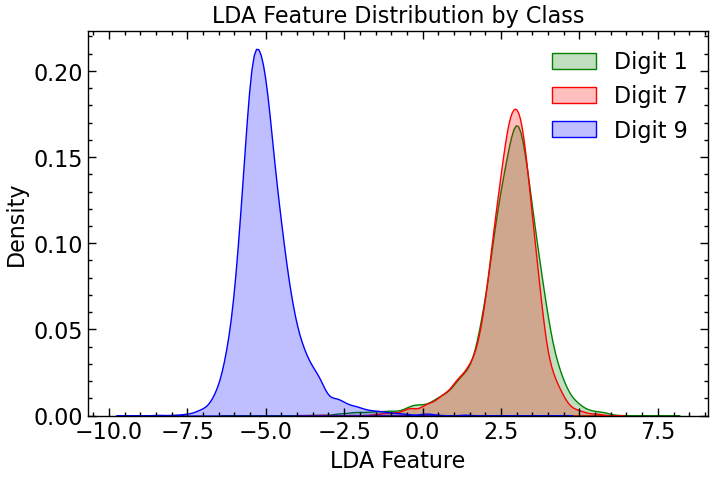

In [21]:
# Plot LDA
# Scatter plot along a single axis (1D)
plt.figure(figsize=(8, 5))
sns.kdeplot(x=X_lda[:, 0], hue=y, fill=True, palette=['blue', 'red', 'green'])
plt.xlabel("LDA Feature")
plt.ylabel("Density")
plt.title("LDA Feature Distribution by Class")
plt.legend(["Digit 1", "Digit 7", "Digit 9"])
plt.show()

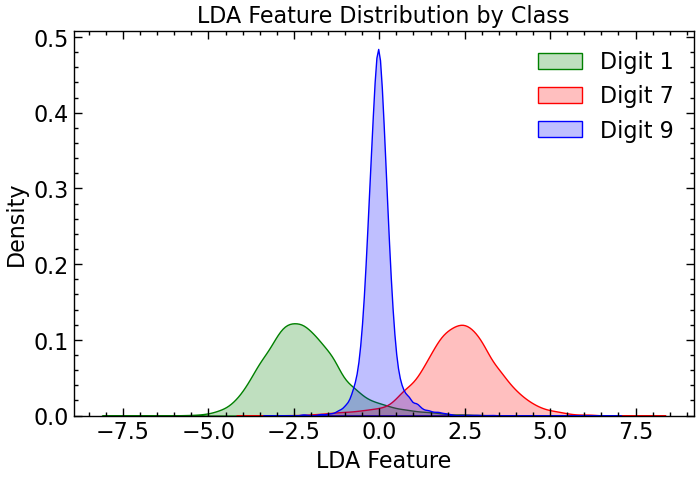

In [22]:
# Plot LDA
# Scatter plot along a single axis (1D)
plt.figure(figsize=(8, 5))
sns.kdeplot(x=X_lda[:, 1], hue=y, fill=True, palette=['blue', 'red', 'green'])
plt.xlabel("LDA Feature")
plt.ylabel("Density")
plt.title("LDA Feature Distribution by Class")
plt.legend(["Digit 1", "Digit 7", "Digit 9"])
plt.show()

In [65]:
print(X_lda.shape)
print(Xtest.shape)
print(Xpool.shape)

(22128, 2)
(21628, 2)
(500, 2)


In [23]:
import sklearn.linear_model as lin
# Xtest=np.concatenate(X_lda[500:])
Xtest=X_lda[500:]
ytest=y[500:]
# Xpool=np.concatenate(X_lda[:500])
Xpool=X_lda[:500]
ypool=y[:500]

lr = lin.LogisticRegression(penalty='l2',C=1.)
model=lr

#randomize order of pool to avoid sampling the same subject sequentially
order=np.random.permutation(range(len(Xpool)))

In [24]:
#samples in the pool
poolidx=np.arange(len(Xpool),dtype=np.int64)
ninit = 10 #initial samples
addn = 5 #samples to add each iteration

#initial training set
trainset=order[:ninit]
# Xtrain1=np.take(Xpool1,trainset1,axis=0).reshape(-1, 1)
Xtrain=np.take(Xpool,trainset,axis=0)

ytrain=np.take(ypool,trainset,axis=0)

#remove data from pool
poolidx=np.setdiff1d(poolidx,trainset)

testacc=[]
for i in range(30):
    #Fit model
    # model.fit(np.take(Xpool,order[:ninit+i*addn],axis=0).reshape(-1, 1), np.take(ypool,order[:ninit+i*addn],axis=0))
    model.fit(np.take(Xpool,order[:ninit+i*addn],axis=0), np.take(ypool,order[:ninit+i*addn],axis=0))

    #predict on test set
    # ye=model.predict(Xtest.reshape(-1, 1))
    ye=model.predict(Xtest)

    #calculate and accuracy and add to list
    testacc.append((ninit+i*addn,sklearn.metrics.accuracy_score(ytest,ye)))
    print('Model: LR, %i random samples'%(ninit+i*addn))

Model: LR, 10 random samples
Model: LR, 15 random samples
Model: LR, 20 random samples
Model: LR, 25 random samples
Model: LR, 30 random samples
Model: LR, 35 random samples
Model: LR, 40 random samples
Model: LR, 45 random samples
Model: LR, 50 random samples
Model: LR, 55 random samples
Model: LR, 60 random samples
Model: LR, 65 random samples
Model: LR, 70 random samples
Model: LR, 75 random samples
Model: LR, 80 random samples
Model: LR, 85 random samples
Model: LR, 90 random samples
Model: LR, 95 random samples
Model: LR, 100 random samples
Model: LR, 105 random samples
Model: LR, 110 random samples
Model: LR, 115 random samples
Model: LR, 120 random samples
Model: LR, 125 random samples
Model: LR, 130 random samples
Model: LR, 135 random samples
Model: LR, 140 random samples
Model: LR, 145 random samples
Model: LR, 150 random samples
Model: LR, 155 random samples


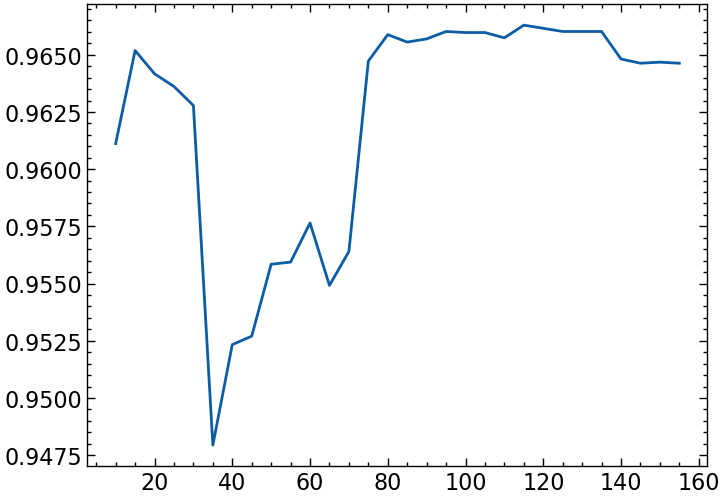

In [25]:
#Plot learning curve
plt.plot(*tuple(np.array(testacc).T));

In [26]:
#reset training set and pool
testacc_qbc=[] #this should hold the final accuracies
ncomm=10
ninit=10
addn=5

trainset=order[:ninit]
Xtrain=np.take(Xpool,trainset,axis=0)

ytrain=np.take(ypool,trainset,axis=0)

poolidx=np.arange(len(Xpool),dtype=np.int64)
poolidx=np.setdiff1d(poolidx,trainset)

for i in range(30):
    ypool_lab=[]
    # fit models in committee
    for k in range(ncomm):
        #bootstrapping
        Xtr,ytr=sklearn.utils.resample(Xtrain,ytrain,stratify=ytrain)
        #fit
        model.fit(Xtr, ytr)
        # Predict
        Xpool_lda = Xpool[poolidx]
        ypool_lab.append(model.predict(Xpool_lda))

    #get probability of label for each class based on voting in the committee
    ypool_p=(np.mean(np.array(ypool_lab)==1,0),np.mean(np.array(ypool_lab)==7,0),np.mean(np.array(ypool_lab)==9,0))
    ypool_p=np.array(ypool_p).T
    #Refit model in all training data
    model.fit(Xtrain,ytrain)
    Xtest_lda = Xtest
    ye=model.predict(Xtest_lda)
    testacc_qbc.append((len(Xtrain),sklearn.metrics.accuracy_score(ytest,ye)))

    #select sample with maximum disagreement (least confident)
    ypool_p_sort_idx = np.argsort(-ypool_p.max(1)) #least confident

    # Add to training set
    Xtrain_new = Xpool[poolidx[ypool_p_sort_idx[-addn:]]]
    Xtrain = np.concatenate((Xtrain, Xtrain_new))
    ytrain = np.concatenate((ytrain, ypool[poolidx[ypool_p_sort_idx[-addn:]]]))
    # #add to training set
    # Xtrain=np.concatenate((Xtrain,Xpool[poolidx[ypool_p_sort_idx[-addn:]]]))
    # ytrain=np.concatenate((ytrain,ypool[poolidx[ypool_p_sort_idx[-addn:]]]))

    #remove from pool
    poolidx=np.setdiff1d(poolidx,poolidx[ypool_p_sort_idx[-addn:]])
    print('Model: LR, %i samples (QBC)'%(ninit+i*addn))


Model: LR, 10 samples (QBC)
Model: LR, 15 samples (QBC)
Model: LR, 20 samples (QBC)
Model: LR, 25 samples (QBC)
Model: LR, 30 samples (QBC)
Model: LR, 35 samples (QBC)
Model: LR, 40 samples (QBC)
Model: LR, 45 samples (QBC)
Model: LR, 50 samples (QBC)
Model: LR, 55 samples (QBC)
Model: LR, 60 samples (QBC)
Model: LR, 65 samples (QBC)
Model: LR, 70 samples (QBC)
Model: LR, 75 samples (QBC)
Model: LR, 80 samples (QBC)
Model: LR, 85 samples (QBC)
Model: LR, 90 samples (QBC)
Model: LR, 95 samples (QBC)
Model: LR, 100 samples (QBC)
Model: LR, 105 samples (QBC)
Model: LR, 110 samples (QBC)
Model: LR, 115 samples (QBC)
Model: LR, 120 samples (QBC)
Model: LR, 125 samples (QBC)
Model: LR, 130 samples (QBC)
Model: LR, 135 samples (QBC)
Model: LR, 140 samples (QBC)
Model: LR, 145 samples (QBC)
Model: LR, 150 samples (QBC)
Model: LR, 155 samples (QBC)


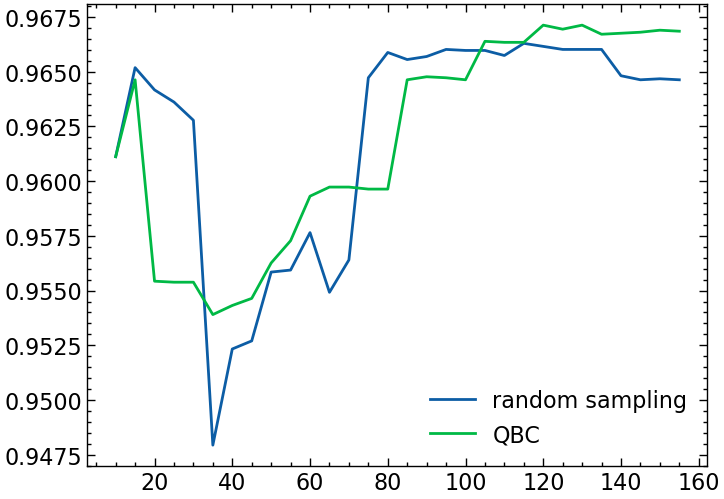

In [27]:
#Plot learning curve
plt.plot(*tuple(np.array(testacc).T));
plt.plot(*tuple(np.array(testacc_qbc).T));
plt.legend(('random sampling','QBC'));

## Train with all 10 classes

In [28]:
# Import dataset with all digits
X_full,y_full = load_dataset()
X,y = filter_dataset(X_full,y_full,"all")
X = X / 255
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


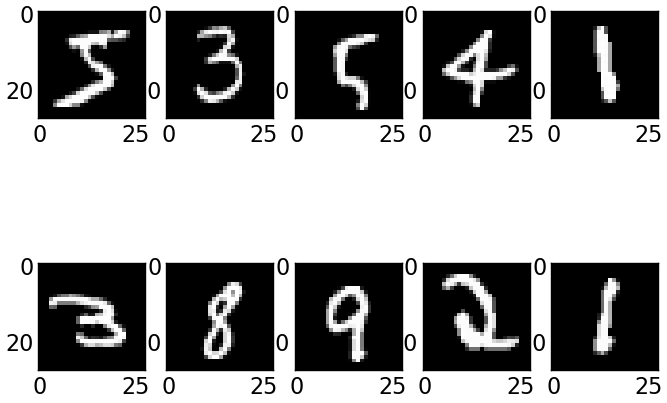

In [29]:
# Plot the squared images
fig, ax = plt.subplots(2, 5)
ax[0, 0].imshow(X[0].reshape(28,28), cmap='gray')
ax[0, 1].imshow(X[50].reshape(28,28), cmap='gray')
ax[0, 2].imshow(X[100].reshape(28,28), cmap='gray')
ax[0, 3].imshow(X[150].reshape(28,28), cmap='gray')
ax[0, 4].imshow(X[200].reshape(28,28), cmap='gray')
ax[1, 0].imshow(X[250].reshape(28,28), cmap='gray')
ax[1, 1].imshow(X[300].reshape(28,28), cmap='gray')
ax[1, 2].imshow(X[350].reshape(28,28), cmap='gray')
ax[1, 3].imshow(X[400].reshape(28,28), cmap='gray')
ax[1, 4].imshow(X[450].reshape(28,28), cmap='gray')
plt.show()

In [30]:
# LDA proves to be much better, since we care more about class separation and nor variance
lda = LinearDiscriminantAnalysis(n_components=5)
Xs = StandardScaler().fit_transform(X)
X_lda = lda.fit_transform(Xs, y)
print("Total variance capture by LDA: ", sum(lda.explained_variance_ratio_))
print("New feature-space shape: ", X_lda.shape)

Total variance capture by LDA:  0.819426626304756
New feature-space shape:  (70000, 5)


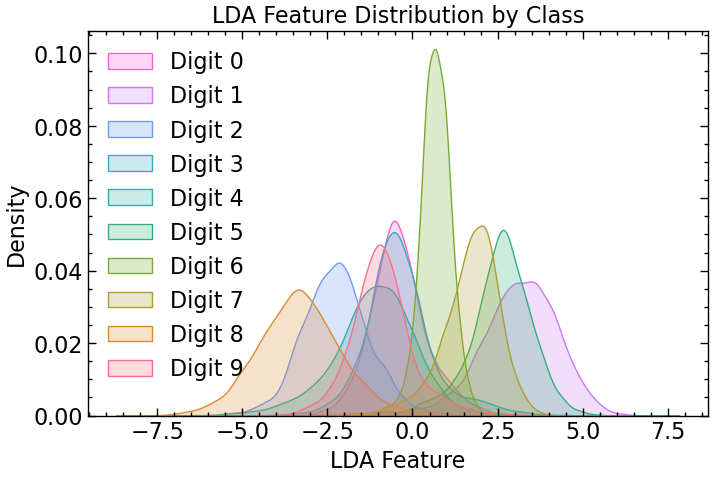

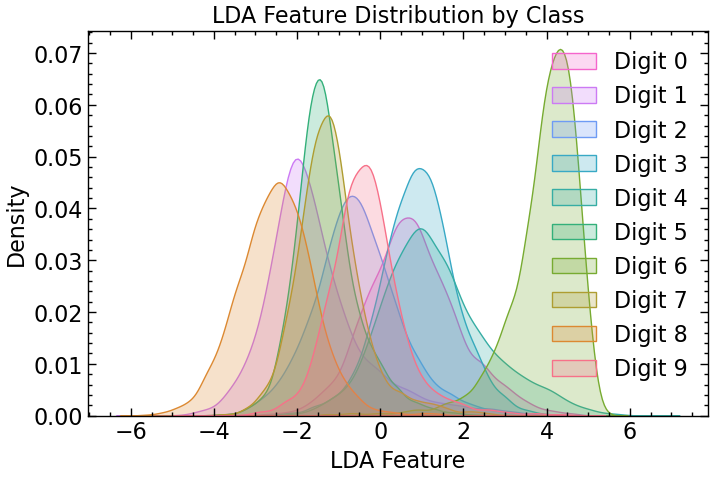

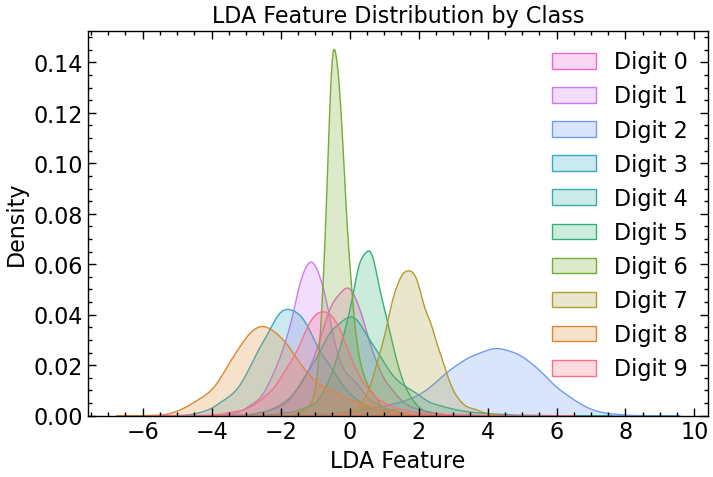

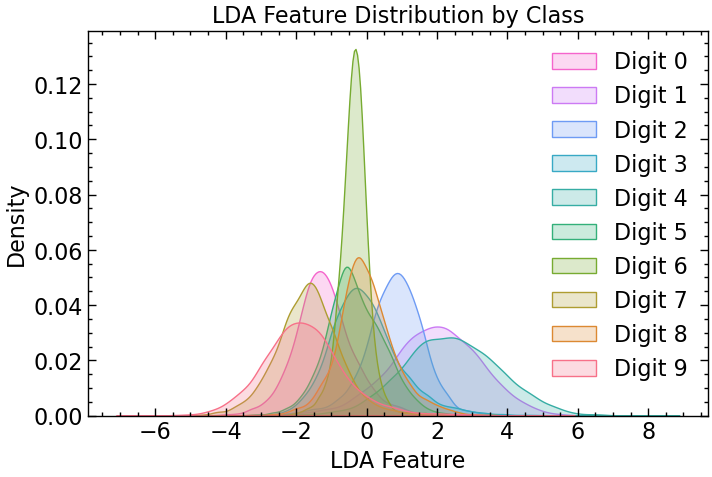

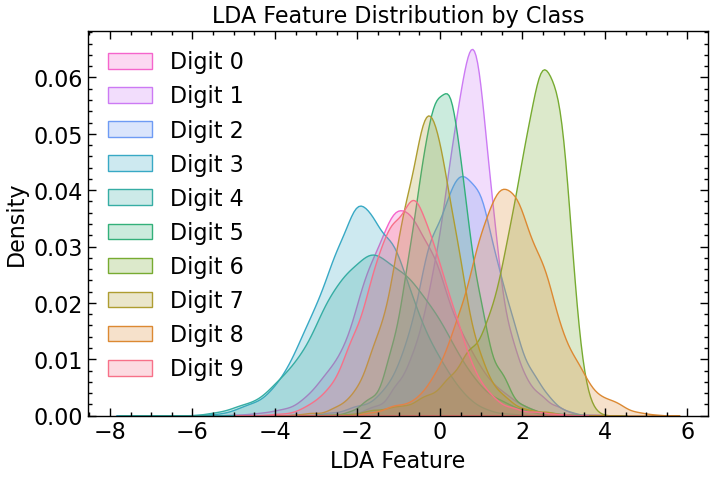

In [31]:
# Plot LDA
# Scatter plot along a single axis (1D)
for i in range(5):
    plt.figure(figsize=(8, 5))
    sns.kdeplot(x=X_lda[:, i], hue=y, fill=True)
    plt.xlabel("LDA Feature")
    plt.ylabel("Density")
    plt.title("LDA Feature Distribution by Class")
    plt.legend(["Digit 0", "Digit 1", "Digit 2", "Digit 3", "Digit 4", "Digit 5", "Digit 6", "Digit 7", "Digit 8", "Digit 9"])
    plt.show()

In [32]:
import sklearn.linear_model as lin
# Xtest=np.concatenate(X_lda[500:])
Xtest=X_lda[500:]
ytest=y[500:]
# Xpool=np.concatenate(X_lda[:500])
Xpool=X_lda[:500]
ypool=y[:500]

lr = lin.LogisticRegression(penalty='l2',C=1.)
model=lr

#randomize order of pool to avoid sampling the same subject sequentially
order=np.random.permutation(range(len(Xpool)))

In [33]:
#samples in the pool
poolidx=np.arange(len(Xpool),dtype=np.int64)
ninit = 10 #initial samples
addn = 10 #samples to add each iteration

#initial training set
trainset=order[:ninit]
# Xtrain1=np.take(Xpool1,trainset1,axis=0).reshape(-1, 1)
Xtrain=np.take(Xpool,trainset,axis=0)

ytrain=np.take(ypool,trainset,axis=0)

#remove data from pool
poolidx=np.setdiff1d(poolidx,trainset)

testacc=[]
for i in range(30):
    #Fit model
    # model.fit(np.take(Xpool,order[:ninit+i*addn],axis=0).reshape(-1, 1), np.take(ypool,order[:ninit+i*addn],axis=0))
    model.fit(np.take(Xpool,order[:ninit+i*addn],axis=0), np.take(ypool,order[:ninit+i*addn],axis=0))

    #predict on test set
    # ye=model.predict(Xtest.reshape(-1, 1))
    ye=model.predict(Xtest)

    #calculate and accuracy and add to list
    testacc.append((ninit+i*addn,sklearn.metrics.accuracy_score(ytest,ye)))
    print('Model: LR, %i random samples'%(ninit+i*addn))

Model: LR, 10 random samples
Model: LR, 20 random samples
Model: LR, 30 random samples
Model: LR, 40 random samples
Model: LR, 50 random samples
Model: LR, 60 random samples
Model: LR, 70 random samples
Model: LR, 80 random samples
Model: LR, 90 random samples
Model: LR, 100 random samples
Model: LR, 110 random samples
Model: LR, 120 random samples
Model: LR, 130 random samples
Model: LR, 140 random samples
Model: LR, 150 random samples
Model: LR, 160 random samples
Model: LR, 170 random samples
Model: LR, 180 random samples
Model: LR, 190 random samples
Model: LR, 200 random samples
Model: LR, 210 random samples
Model: LR, 220 random samples
Model: LR, 230 random samples
Model: LR, 240 random samples
Model: LR, 250 random samples
Model: LR, 260 random samples
Model: LR, 270 random samples
Model: LR, 280 random samples
Model: LR, 290 random samples
Model: LR, 300 random samples


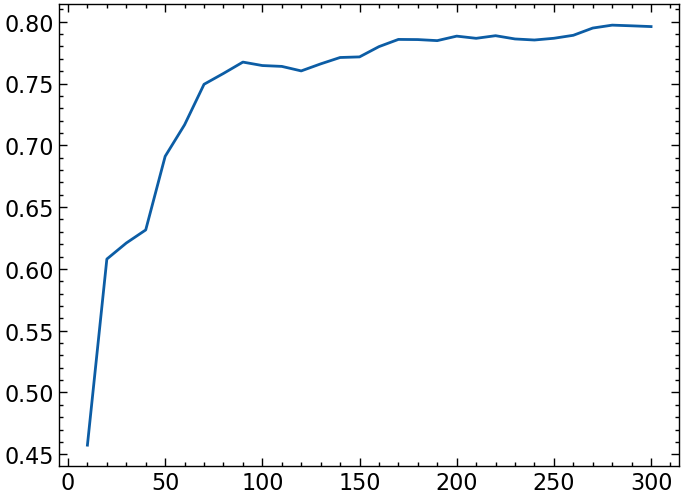

In [34]:
#Plot learning curve
plt.plot(*tuple(np.array(testacc).T));

In [37]:
#reset training set and pool
testacc_qbc=[] #this should hold the final accuracies
ncomm=10
ninit=10
addn=10

trainset=order[:ninit]
Xtrain=np.take(Xpool,trainset,axis=0)

ytrain=np.take(ypool,trainset,axis=0)

poolidx=np.arange(len(Xpool),dtype=np.int64)
poolidx=np.setdiff1d(poolidx,trainset)

for i in range(30):
    ypool_lab=[]
    # fit models in committee
    for k in range(ncomm):
        #bootstrapping
        Xtr,ytr=sklearn.utils.resample(Xtrain,ytrain,stratify=ytrain)
        #fit
        model.fit(Xtr, ytr)
        # Predict
        Xpool_lda = Xpool[poolidx]
        ypool_lab.append(model.predict(Xpool_lda))

    #get probability of label for each class based on voting in the committee
    ypool_p=(np.mean(np.array(ypool_lab)==0,0), np.mean(np.array(ypool_lab)==1,0),np.mean(np.array(ypool_lab)==2,0),np.mean(np.array(ypool_lab)==3,0),np.mean(np.array(ypool_lab)==4,0),np.mean(np.array(ypool_lab)==5,0),np.mean(np.array(ypool_lab)==6,0),np.mean(np.array(ypool_lab)==7,0),np.mean(np.array(ypool_lab)==8,0),np.mean(np.array(ypool_lab)==9,0))
    ypool_p=np.array(ypool_p).T
    #Refit model in all training data
    model.fit(Xtrain,ytrain)
    Xtest_lda = Xtest
    ye=model.predict(Xtest_lda)
    testacc_qbc.append((len(Xtrain),sklearn.metrics.accuracy_score(ytest,ye)))

    #select sample with maximum disagreement (least confident)
    ypool_p_sort_idx = np.argsort(-ypool_p.max(1)) #least confident

    # Add to training set
    Xtrain_new = Xpool[poolidx[ypool_p_sort_idx[-addn:]]]
    Xtrain = np.concatenate((Xtrain, Xtrain_new))
    ytrain = np.concatenate((ytrain, ypool[poolidx[ypool_p_sort_idx[-addn:]]]))
    # #add to training set
    # Xtrain=np.concatenate((Xtrain,Xpool[poolidx[ypool_p_sort_idx[-addn:]]]))
    # ytrain=np.concatenate((ytrain,ypool[poolidx[ypool_p_sort_idx[-addn:]]]))

    #remove from pool
    poolidx=np.setdiff1d(poolidx,poolidx[ypool_p_sort_idx[-addn:]])
    print('Model: LR, %i samples (QBC)'%(ninit+i*addn))


Model: LR, 10 samples (QBC)
Model: LR, 20 samples (QBC)
Model: LR, 30 samples (QBC)
Model: LR, 40 samples (QBC)
Model: LR, 50 samples (QBC)
Model: LR, 60 samples (QBC)
Model: LR, 70 samples (QBC)
Model: LR, 80 samples (QBC)
Model: LR, 90 samples (QBC)
Model: LR, 100 samples (QBC)
Model: LR, 110 samples (QBC)
Model: LR, 120 samples (QBC)
Model: LR, 130 samples (QBC)
Model: LR, 140 samples (QBC)
Model: LR, 150 samples (QBC)
Model: LR, 160 samples (QBC)
Model: LR, 170 samples (QBC)
Model: LR, 180 samples (QBC)
Model: LR, 190 samples (QBC)
Model: LR, 200 samples (QBC)
Model: LR, 210 samples (QBC)
Model: LR, 220 samples (QBC)
Model: LR, 230 samples (QBC)
Model: LR, 240 samples (QBC)
Model: LR, 250 samples (QBC)
Model: LR, 260 samples (QBC)
Model: LR, 270 samples (QBC)
Model: LR, 280 samples (QBC)
Model: LR, 290 samples (QBC)
Model: LR, 300 samples (QBC)


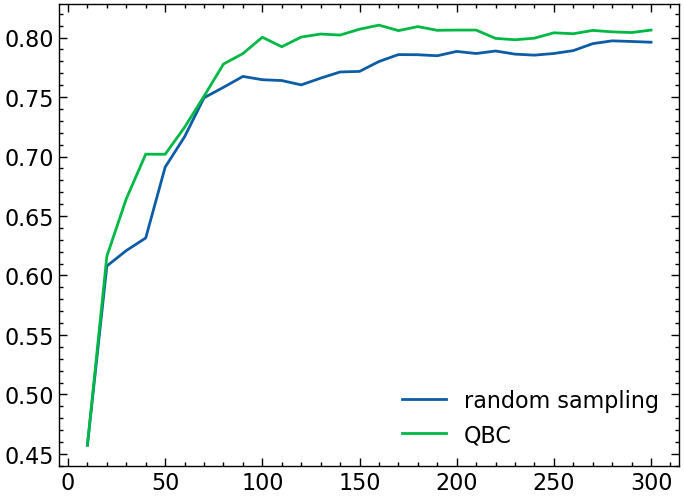

In [38]:
#Plot learning curve
plt.plot(*tuple(np.array(testacc).T));
plt.plot(*tuple(np.array(testacc_qbc).T));
plt.legend(('random sampling','QBC'));